## Task3

在这个任务中，数据集被划分为了训练集何交叉验证集，我们需要利用交叉验证集来选择最合适的参数（$C$ 和 $\sigma$）

In [69]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from scipy.io import loadmat

import numpy as np
import pandas as pd

## load data

In [70]:
mat = loadmat('data/ex6data3.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [71]:
training = pd.DataFrame(mat['X'], columns=['X1', 'X2'])
training['y'] = mat['y']

cv = pd.DataFrame(mat['Xval'], columns=['X1', 'X2'])
cv['y'] = mat['yval']

training.shape, cv.shape

((211, 3), (200, 3))

In [72]:
training.head()

,X1,X2,y
0,-0.158986,0.423977,1
1,-0.347926,0.470760,1
2,-0.504608,0.353801,1
3,-0.596774,0.114035,1
4,-0.518433,-0.172515,1


In [73]:
cv.head()

,X1,X2,y
0,-0.353062,-0.673902,0
1,-0.227126,0.447320,1
2,0.092898,-0.753524,0
3,0.148243,-0.718473,0
4,-0.001512,0.162928,0


## visualization

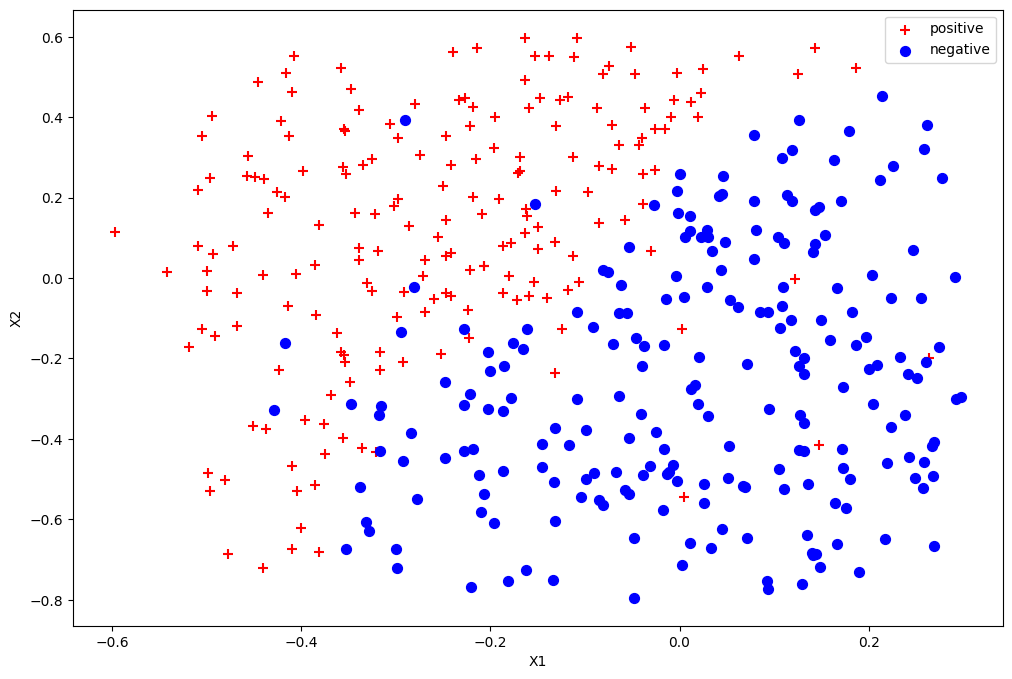

In [74]:
import matplotlib.pyplot as plt

data = pd.concat([training, cv], axis=0, ignore_index=True)
positive = data[data.y == 1]
negative = data[data['y'] == 0]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['X1'], positive['X2'], label='positive', s=50, marker='+', c='r')
ax.scatter(negative['X1'], negative['X2'], label='negative', s=50, marker='o', c='b')
ax.legend(loc='best')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

## manual grid search $C$ and $\sigma$

手动寻找最优参数

In [75]:
candidate = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
combination = [(C, gamma) for C in candidate for gamma in candidate]
len(combination)

81

In [76]:
search = []

for C, gamma in combination:
    svc = svm.SVC(C=C, gamma=gamma)
    svc.fit(training[['X1', 'X2']], training['y'])
    search.append(svc.score(cv[['X1', 'X2']], cv['y']))

In [77]:
best_score = search[np.argmax(search)]
best_param = combination[np.argmax(search)]
best_score, best_param

(0.965, (0.3, 100))

In [78]:
best_svc = svm.SVC(C = best_param[0], gamma=best_param[1])
best_svc.fit(training[['X1', 'X2']], training['y'])
y_pred = best_svc.predict(cv[['X1', 'X2']])

print(metrics.classification_report(cv['y'], y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       113
           1       0.95      0.97      0.96        87

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



## decision boundary

In [79]:
min(data['X1']), max(data['X1']), min(data['X2']), max(data['X2'])

(-0.596774, 0.297235, -0.7948161385602274, 0.5975321589468918)

In [80]:
def show_decision_boundary(clf):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(positive['X1'], positive['X2'], label='positive', s=50, marker='+', c='r')
    ax.scatter(negative['X1'], negative['X2'], label='negative', s=50, marker='o', c='b')
    ax.legend(loc='best')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    x1 = np.arange(-0.65, 0.3, 0.01)
    x2 = np.arange(-0.9, 0.6, 0.01)
    x1, x2 = np.meshgrid(x1, x2)
    xx = np.vstack((x1.ravel(), x2.ravel())).T
    xx_df = pd.DataFrame(xx, columns=['X1', 'X2'])
    y_pred = clf.predict(xx_df).reshape(x1.shape)
    plt.contour(x1, x2, y_pred, colors='g', linewidths=.5)

    plt.show()

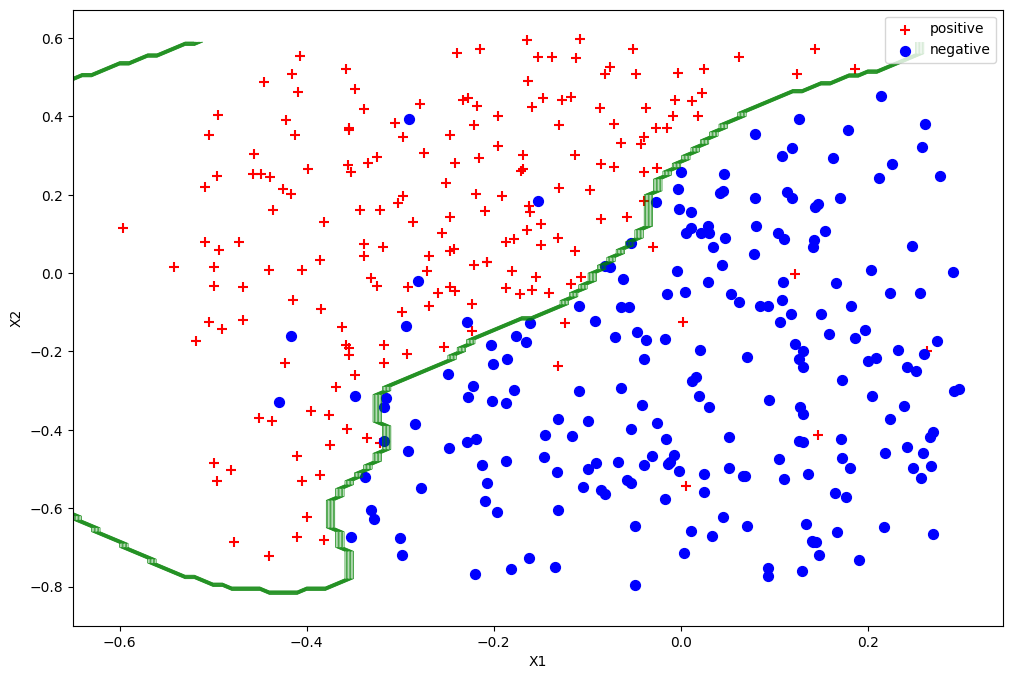

In [81]:
show_decision_boundary(best_svc)

## sklearn grid search cv

In [82]:
parameters = {'C': candidate, 'gamma': candidate}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(training[['X1', 'X2']], training['y'])

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]})

In [83]:
clf.best_params_

{'C': 30, 'gamma': 3}

In [84]:
clf.best_score_

0.9194905869324475

In [85]:
y_pred = clf.predict(cv[['X1', 'X2']])
print(metrics.classification_report(cv['y'], y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       113
           1       0.95      0.93      0.94        87

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



## decision boundary

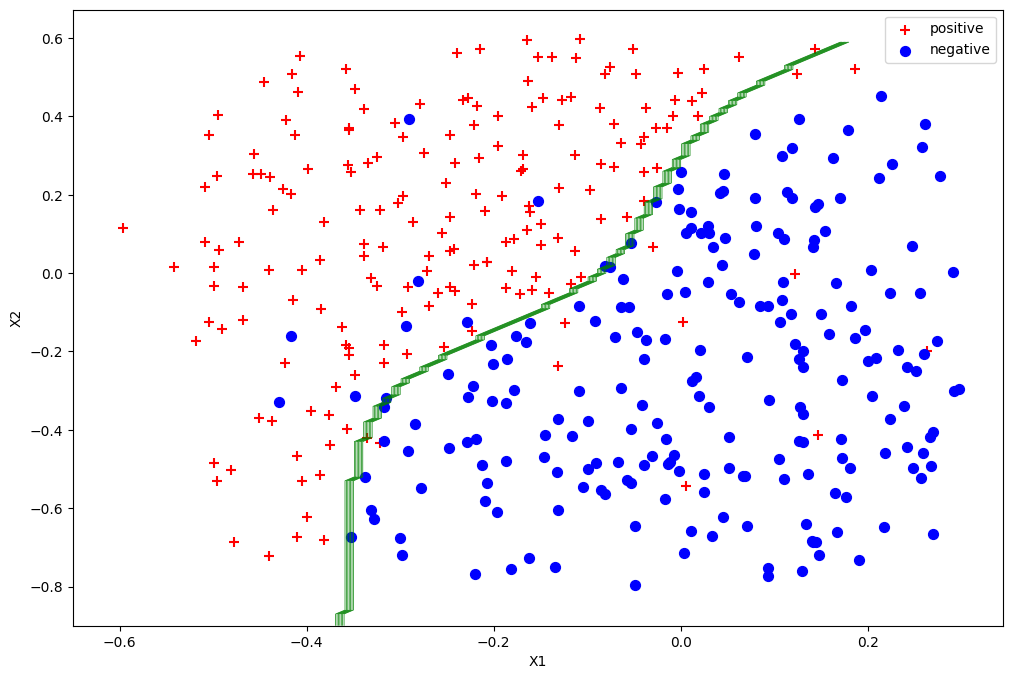

In [86]:
show_decision_boundary(clf)

The reason for different result is that GridSearch is using part of training data to train

since it need part of data as cross validate set to get the best parameters, but the manual grid search has additional cv data set.

In [87]:
all = res = pd.concat([training, cv], axis=0, ignore_index=True)
all.shape

(411, 3)

In [88]:
parameters = {'C': candidate, 'gamma': candidate}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(all[['X1', 'X2']], all['y'])

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]})

In [89]:
clf.best_params_, clf.best_score_

({'C': 1, 'gamma': 10}, 0.9489861886570672)

In [90]:
y_pred = clf.predict(cv[['X1', 'X2']])
print(metrics.classification_report(cv['y'], y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       113
           1       0.95      0.97      0.96        87

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



## decision boundary

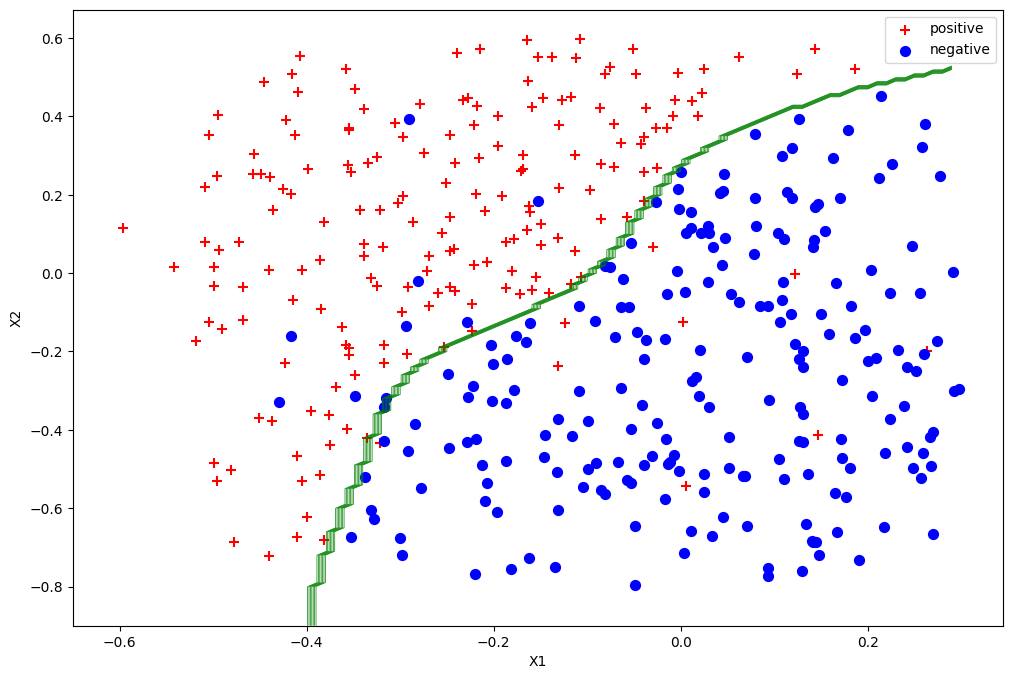

In [91]:
show_decision_boundary(clf)